In [101]:
import os
import sys
import random
import importlib
import numpy as np
import cv2
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

import config # 1. 모듈 자체를 import
importlib.reload(config) # 2. 강제로 파일을 다시 읽어서 메모리 갱신
from config import Config # 3. 갱신된 모듈에서 클래스를 다시 가져옴
print("✅ Config 파일이 새로 갱신되었습니다.")

# 노트북 내에서 그래프를 바로 보기 위한 매직 커맨드
%matplotlib inline

# 시드 고정 (시각화 색상 일관성을 위해)
def set_seed(seed=21):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

set_seed(21)
print("Library Loaded & Seed Set.")

✅ Config 파일이 새로 갱신되었습니다.
Library Loaded & Seed Set.


In [102]:
def decode_mask_to_colormap(mask):
    """
    (29, H, W) 형태의 마스크를 알록달록한 (H, W, 3) 이미지로 변환
    """
    H, W = mask.shape[1], mask.shape[2]
    colormap = np.zeros((H, W, 3), dtype=np.uint8)
    
    # 클래스별 고유 색상 생성
    np.random.seed(21)
    colors = [np.random.randint(50, 255, 3).tolist() for _ in range(len(Config.CLASSES))]
    
    for c in range(len(Config.CLASSES)):
        class_mask = mask[c]
        if class_mask.max() > 0:
            color = colors[c]
            # 해당 클래스 영역에 색상 입히기
            colormap[class_mask > 0.5] = color
            
    return colormap

def get_error_colormap(gt_mask, pred_mask):
    """
    정답과 예측의 차이를 시각화 (Error Analysis)
    - Red: False Negative (놓친 것)
    - Blue: False Positive (잘못 예측한 것)
    """
    # 29개 클래스를 하나로 합쳐서(Max projection) "뼈가 있냐 없냐"로 단순화하여 비교
    # (클래스가 틀린 경우까지 보려면 argmax를 써야 하지만, 여기서는 형태학적 오류에 집중)
    gt_binary = np.max(gt_mask, axis=0) > 0.5
    pred_binary = np.max(pred_mask, axis=0) > 0.5
    
    H, W = gt_binary.shape
    error_map = np.zeros((H, W, 3), dtype=np.uint8)
    
    # 1. False Negative (Miss): 정답은 있는데(True), 예측은 없다고(False) 함 -> 빨강
    fn_mask = np.logical_and(gt_binary, ~pred_binary)
    error_map[fn_mask] = [255, 0, 0] # Red
    
    # 2. False Positive (Noise): 정답은 없는데(False), 예측은 있다고(True) 함 -> 파랑
    fp_mask = np.logical_and(~gt_binary, pred_binary)
    error_map[fp_mask] = [0, 0, 255] # Blue
    
    return error_map

In [103]:
# 1. Config에 정의된 모듈 동적 로드
try:
    dataset_module = importlib.import_module(Config.DATASET_FILE)
    XRayDataset = dataset_module.XRayDataset
    get_transforms = dataset_module.get_transforms
    print(f">> Dataset Loaded from: {Config.DATASET_FILE}")
except Exception as e:
    print(f"❌ Error loading dataset module: {e}")

# 2. 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_path = os.path.join(Config.SAVED_DIR, "best_model.pt")

if not os.path.exists(model_path):
    print(f"❌ Model not found at: {model_path}")
    print("  -> 학습이 완료되었는지, 경로가 맞는지 확인해주세요.")
else:
    print(f">> Loading Model from: {model_path}")
    try:
        # [수정된 부분] weights_only=False 옵션 추가!
        model = torch.load(model_path, map_location=device, weights_only=False)
        print("✅ Model loaded successfully!")
    except Exception as e:
        print(f"❌ Model load failed: {e}")
        
    model.eval()

# 3. Validation 데이터셋 준비
valid_dataset = XRayDataset(is_train=False, transforms=get_transforms(is_train=False))

# 시각화를 위해 Shuffle=True로 설정
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=0)

print(f">> Validation Set Size: {len(valid_dataset)} images ready.")

>> Dataset Loaded from: dataset.dataset_xnormalize
>> Loading Model from: checkpoints/WJH_009_unetb2_dicetest_xnormalize/best_model.pt
✅ Model loaded successfully!
>> Validation Set Size: 160 images ready.


🔎 ID 'ID001' 검색 성공! -> Index 0: ID001/image1661130828152_R.png


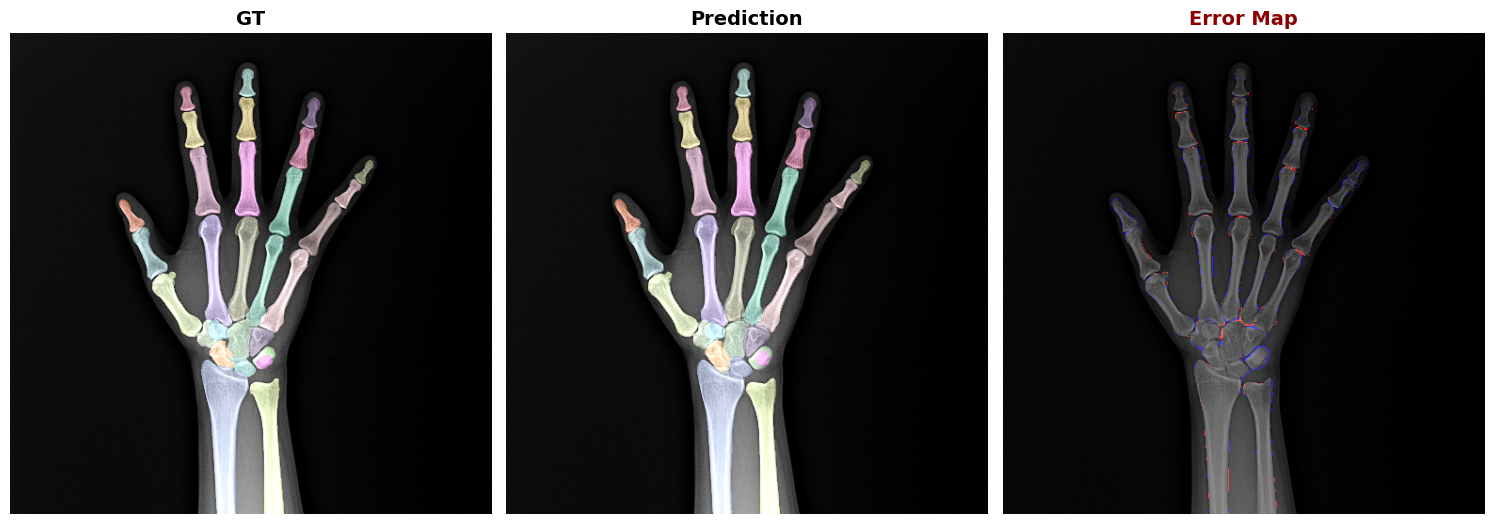

In [104]:
# ==========================================
# [사용자 설정] 보고 싶은 이미지를 지정하세요
# ==========================================
TARGET_ID = "ID001"   # 보고 싶은 ID 또는 Index (예: 10)
ALPHA = 0.4          # 투명도

# ==========================================
# [검색 로직] Dataset에서 이미지 찾기
# ==========================================
def find_data_by_target(dataset, target):
    if isinstance(target, int):
        if 0 <= target < len(dataset):
            print(f"📌 Index {target} 선택됨: {dataset.filenames[target]}")
            return dataset[target]
    elif isinstance(target, str):
        for i, fname in enumerate(dataset.filenames):
            if target in fname:
                print(f"🔎 ID '{target}' 검색 성공! -> Index {i}: {fname}")
                return dataset[i]
    
    # 못 찾으면 첫 번째 거 반환
    print(f"⚠️ '{target}'를 찾을 수 없어 첫 번째 이미지를 가져옵니다.")
    return dataset[0]

# 1. 데이터 가져오기
image, mask = find_data_by_target(valid_dataset, TARGET_ID)

# 2. 배치 차원 추가
images = image.unsqueeze(0).to(device)
masks = mask.unsqueeze(0).to(device)

# 3. 추론
with torch.no_grad():
    if device == 'cuda':
        with torch.amp.autocast(device_type="cuda"):
            outputs = model(images)
            if isinstance(outputs, dict): outputs = outputs['out']
    else:
        outputs = model(images)
        if isinstance(outputs, dict): outputs = outputs['out']

    if outputs.shape[-2:] != masks.shape[-2:]:
        outputs = F.interpolate(outputs, size=masks.shape[-2:], mode="bilinear", align_corners=False)

    preds = (torch.sigmoid(outputs) > 0.5).float()

# =========================================================================
# 🚑 [핵심 수정] 이미지 역정규화 (Denormalization)
# =========================================================================
img_np = images[0].cpu().permute(1, 2, 0).numpy()

# 1. 정규화가 되어 있는지 확인 (최소값이 음수면 정규화된 것임)
if img_np.min() < 0:
    print("ℹ️ Normalized Image Detected -> Denormalizing...")
    # ImageNet Mean/Std (일반적인 경우)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # 역정규화: (img * std) + mean
    img_np = (img_np * std) + mean
    
    # 값 범위를 0~1로 클리핑 (노이즈 제거)
    img_np = np.clip(img_np, 0, 1)

# 2. 0~255 스케일로 변환
img_np = (img_np * 255).astype(np.uint8).copy()

# 3. Grayscale 처리 (RGB 변환)
if img_np.shape[2] == 1:
    img_np = cv2.cvtColor(img_np, cv2.COLOR_GRAY2RGB)
# =========================================================================

# (B) 마스크 및 에러맵
gt_mask_np = masks[0].cpu().numpy()
pred_mask_np = preds[0].cpu().numpy()

gt_colormap = decode_mask_to_colormap(gt_mask_np)
pred_colormap = decode_mask_to_colormap(pred_mask_np)
error_colormap = get_error_colormap(gt_mask_np, pred_mask_np)

# (C) 오버레이
gt_overlay = cv2.addWeighted(img_np, 1, gt_colormap, ALPHA, 0)
pred_overlay = cv2.addWeighted(img_np, 1, pred_colormap, ALPHA, 0)
error_overlay = cv2.addWeighted(img_np, 0.6, error_colormap, 0.9, 0)

# --- 화면 출력 ---
plt.figure(figsize=(20, 6))

plt.subplot(1, 4, 1)
plt.imshow(gt_overlay)
plt.title(f"GT", fontsize=14, fontweight='bold')
plt.axis("off")

plt.subplot(1, 4, 2)
plt.imshow(pred_overlay)
plt.title("Prediction", fontsize=14, fontweight='bold')
plt.axis("off")

plt.subplot(1, 4, 3)
plt.imshow(error_overlay)
plt.title("Error Map", fontsize=14, fontweight='bold', color='darkred')
plt.axis("off")

plt.tight_layout()
plt.show()

>> 🤖 모델 준비 중...
📌 분석 대상: ID001/image1661130828152_R.png


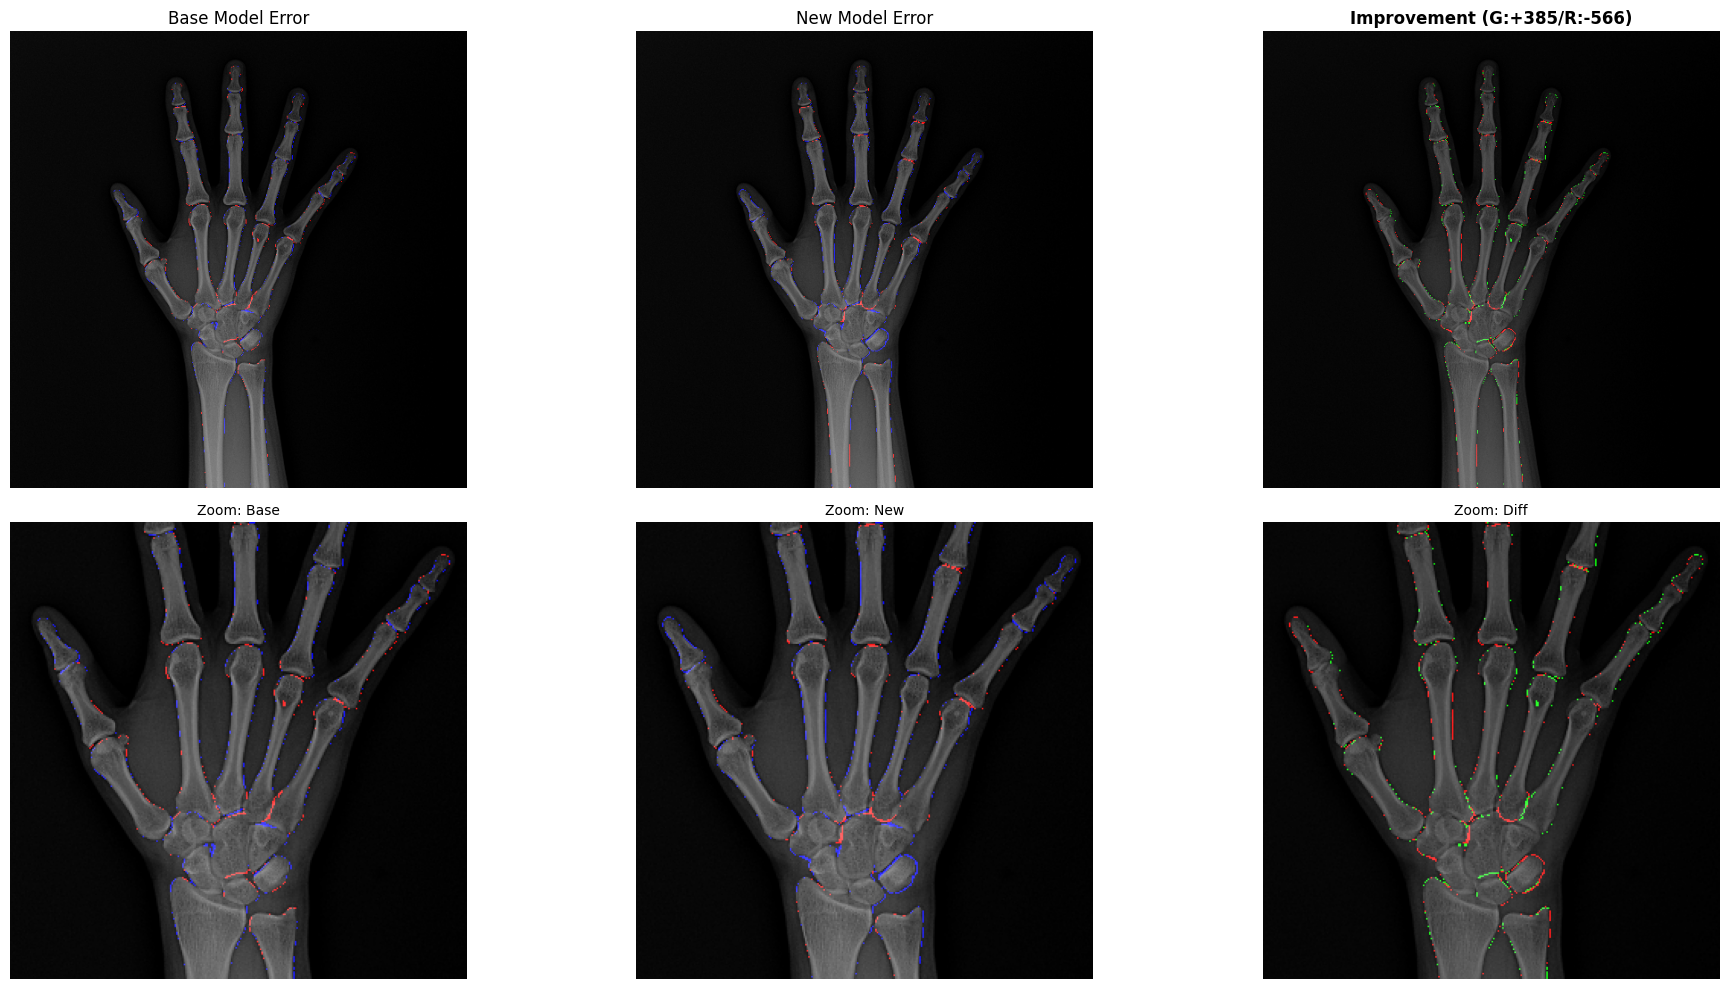

📊 ID001/image1661130828152_R.png 분석 완료: Net Gain -181


In [110]:

# ==================================================================
# ⚙️ [User Config] 비교할 모델과 데이터셋 경로 설정
# ==================================================================
# 1. Base 모델 (기준) 설정
BASE_MODEL_PATH = "checkpoints/Base_UNet/best_model.pt"
BASE_DATASET_MODULE = "dataset.dataset"   # 예: dataset.dataset (파일명에 맞게 수정)

# 2. New 모델 (비교 대상) 설정
NEW_MODEL_PATH = model_path
# New 모델은 현재 Config에 적힌 데이터셋 파일을 자동으로 따라갑니다.
NEW_DATASET_MODULE = Config.DATASET_FILE 

# 3. 분석할 이미지 ID
TARGET_ID = "ID001"  # 또는 인덱스 번호 (예: 10)
ALPHA = 0.4          # 시각화 투명도

# ==================================================================
# 🛠️ Helper Functions
# ==================================================================
def load_model_safely(path, device):
    if not os.path.exists(path):
        print(f"❌ 모델 파일 없음: {path}")
        return None
    try:
        return torch.load(path, map_location=device, weights_only=False).eval()
    except Exception as e:
        print(f"❌ 모델 로드 에러: {e}")
        return None

def get_data_from_dataset_module(module_name, target_id):
    """
    핵심 함수: 지정된 데이터셋 모듈(dataset.py)을 로드하고,
    그 안의 XRayDataset 클래스를 통해 전처리가 완료된 Tensor를 받아옵니다.
    """
    try:
        # 1. 모듈 동적 로드
        module = importlib.import_module(module_name)
        
        # 2. XRayDataset 및 Transforms 가져오기
        XRayDataset = getattr(module, "XRayDataset")
        get_transforms = getattr(module, "get_transforms")
        
        # 3. 데이터셋 인스턴스 생성 (Validation 모드)
        # 여기서 resize 등 모든 전처리가 결정됩니다.
        dataset = XRayDataset(is_train=False, transforms=get_transforms(is_train=False))
        
        # 4. Target ID 찾기
        found_idx = -1
        fname = ""
        
        if isinstance(target_id, int):
            if 0 <= target_id < len(dataset):
                found_idx = target_id
                fname = dataset.filenames[target_id]
        else:
            # 문자열 ID로 검색
            for i, name in enumerate(dataset.filenames):
                if target_id in name:
                    found_idx = i
                    fname = name
                    break
        
        if found_idx == -1:
            print(f"⚠️ {module_name}에서 '{target_id}'를 찾을 수 없습니다.")
            return None, None, None
            
        # 5. 데이터 가져오기 (__getitem__ 호출)
        # dataset.py 로직에 의해 이미 리사이즈된 Tensor가 반환됩니다.
        image_tensor, mask_tensor = dataset[found_idx]
        
        return image_tensor, mask_tensor, fname

    except Exception as e:
        print(f"❌ 데이터셋 로드 실패 ({module_name}): {e}")
        return None, None, None

def get_visualization_maps(gt_mask, pred_mask, img_shape):
    """시각화용 컬러맵 생성 (Resize 포함)"""
    # 크기 통일 (시각화를 위해 pred와 gt를 img_shape에 맞춤)
    if gt_mask.shape != img_shape:
        gt_mask = cv2.resize(gt_mask.astype(float), (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)
    if pred_mask.shape != img_shape:
        pred_mask = cv2.resize(pred_mask.astype(float), (img_shape[1], img_shape[0]), interpolation=cv2.INTER_NEAREST)
        
    gt_b = np.max(gt_mask, axis=0) > 0.5
    pred_b = np.max(pred_mask, axis=0) > 0.5
    
    # Error Map
    err_map = np.zeros((img_shape[0], img_shape[1], 3), dtype=np.uint8)
    err_map[np.logical_and(gt_b, ~pred_b)] = [255, 0, 0] # Miss
    err_map[np.logical_and(~gt_b, pred_b)] = [0, 0, 255] # Noise
    
    return err_map, gt_b, pred_b

# ==================================================================
# 🚀 Main Execution Logic
# ==================================================================
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1. 모델 로드
print(f">> 🤖 모델 준비 중...")
base_model = load_model_safely(BASE_MODEL_PATH, device)
new_model = load_model_safely(NEW_MODEL_PATH, device)

if base_model and new_model:
    # 2. 각 데이터셋 모듈을 통해 데이터 가져오기 (Dual Loader)
    # 🌟 여기가 핵심: 각자 자신의 dataset.py 규칙대로 가져옴 (512든 1024든 상관없음)
    img_t_base, mask_t_base, fname = get_data_from_dataset_module(BASE_DATASET_MODULE, TARGET_ID)
    img_t_new, mask_t_new, _ = get_data_from_dataset_module(NEW_DATASET_MODULE, TARGET_ID)
    
    if img_t_base is not None and img_t_new is not None:
        print(f"📌 분석 대상: {fname}")
        
        # 3. 추론 (Inference)
        with torch.no_grad():
            # Base 추론
            input_base = img_t_base.unsqueeze(0).to(device) # (1, C, H, W)
            out_base = base_model(input_base)
            if isinstance(out_base, dict): out_base = out_base['out']
            pred_base = (torch.sigmoid(out_base) > 0.5).float().cpu().numpy()[0] # (C, H, W)

            # New 추론
            input_new = img_t_new.unsqueeze(0).to(device)
            out_new = new_model(input_new)
            if isinstance(out_new, dict): out_new = out_new['out']
            pred_new = (torch.sigmoid(out_new) > 0.5).float().cpu().numpy()[0]

        # 4. 시각화 준비 (크기 자동 맞춤)
        # 배경으로 쓸 이미지는 New 모델의 해상도(예: 1024)를 기준으로 잡음 (고해상도 선호)
        target_h, target_w = img_t_new.shape[1], img_t_new.shape[2]
        
        # 배경 이미지 복원 (Normalize 역변환은 생략하고 단순 시각화용 흑백/RGB 변환)
        # (정확한 시각화를 위해 원본 파일을 한 번 읽어서 리사이즈)
        raw_img_path = os.path.join(Config.IMAGE_ROOT, fname)
        vis_img = cv2.imread(raw_img_path)
        if vis_img is not None:
            vis_img = cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB)
            vis_img = cv2.resize(vis_img, (target_w, target_h))
        else:
            vis_img = np.zeros((target_h, target_w, 3), dtype=np.uint8)

        # 5. 맵 생성 (Base, New 크기가 달라도 target_h/w에 맞춰짐)
        gt_mask_np = mask_t_new.numpy() # GT는 New 데이터셋 기준 사용
        
        err_base, _, base_b = get_visualization_maps(mask_t_base.numpy(), pred_base, (target_h, target_w))
        err_new, _, new_b   = get_visualization_maps(mask_t_new.numpy(), pred_new, (target_h, target_w))
        
        # Diff Map 계산
        # (이미 위 함수에서 크기를 target_h, target_w로 통일했으므로 바로 비교 가능)
        gt_b = np.max(gt_mask_np, axis=0) > 0.5
        # gt_b 크기 보정 (만약 New 데이터셋이 리사이즈되었다면)
        if gt_b.shape != (target_h, target_w):
             gt_b = cv2.resize(gt_b.astype(float), (target_w, target_h), interpolation=cv2.INTER_NEAREST) > 0.5

        diff_map = np.zeros((target_h, target_w, 3), dtype=np.uint8)
        # 개선 (Green): Base(X) -> New(O)
        diff_map[np.logical_and(base_b != gt_b, new_b == gt_b)] = [0, 255, 0]
        # 퇴보 (Red): Base(O) -> New(X)
        diff_map[np.logical_and(base_b == gt_b, new_b != gt_b)] = [255, 0, 0]
        
        imp_cnt = np.sum(diff_map[..., 1] > 0)
        reg_cnt = np.sum(diff_map[..., 0] > 0)

        # 6. 오버레이 및 출력
        ov_base = cv2.addWeighted(vis_img, 0.6, err_base, 1.0, 0)
        ov_new = cv2.addWeighted(vis_img, 0.6, err_new, 1.0, 0)
        ov_diff = cv2.addWeighted(vis_img, 0.5, diff_map, 1.0, 0)

        plt.figure(figsize=(20, 10))

        plt.subplot(2, 3, 1); plt.imshow(ov_base); plt.title("Base Model Error", fontsize=12); plt.axis('off')
        plt.subplot(2, 3, 2); plt.imshow(ov_new); plt.title("New Model Error", fontsize=12); plt.axis('off')
        plt.subplot(2, 3, 3); plt.imshow(ov_diff); plt.title(f"Improvement (G:+{imp_cnt}/R:-{reg_cnt})", fontsize=12, fontweight='bold'); plt.axis('off')

        # Zoom
        if imp_cnt + reg_cnt > 0:
            ys, xs = np.where(np.max(diff_map, axis=2) > 0)
            cy, cx = int(np.mean(ys)), int(np.mean(xs))
        else:
            cy, cx = target_h // 2, target_w // 2
        
        crop = 150
        y1, y2 = max(0, cy-crop), min(target_h, cy+crop)
        x1, x2 = max(0, cx-crop), min(target_w, cx+crop)

        plt.subplot(2, 3, 4); plt.imshow(ov_base[y1:y2, x1:x2]); plt.title("Zoom: Base", fontsize=10); plt.axis('off')
        plt.subplot(2, 3, 5); plt.imshow(ov_new[y1:y2, x1:x2]); plt.title("Zoom: New", fontsize=10); plt.axis('off')
        plt.subplot(2, 3, 6); plt.imshow(ov_diff[y1:y2, x1:x2]); plt.title("Zoom: Diff", fontsize=10); plt.axis('off')

        plt.tight_layout()
        plt.show()

        print(f"📊 {fname} 분석 완료: Net Gain {imp_cnt - reg_cnt}")

    else:
        print("❌ 데이터를 가져오는데 실패했습니다.")
else:
    print("❌ 모델 로드 실패")